#### Project in CMPE 252, Spring 2022, SJSU.

**Model-free learing in the tabular case by Q-learning**.

your team number and names.

Team 11:

Rutvik Patel <br />
Jay Patel <br />
Chennu Govind

In [2]:
#Importing the necessary libraries:
import matplotlib.pyplot as plt

from IPython.display import clear_output
import numpy as np
import random
import copy
%matplotlib inline

Initialize the environment as per the problem statement:

In [3]:
GRID_SIZE = 17

# rewards
R_GOAL = 0
R_HIT_WALL = -5
R_STEP = -1 # each step is penalized, which encourage the agent
            # to look for the shortest path to the goal state

START = (0, 0)
GOAL = (GRID_SIZE - 1, GRID_SIZE - 1)

# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]

# Noise in transition 
ALPHA = 0.01


A_LIST = ['up', 'down', 'left', 'right', 'stay']

# lenght of an episode
EPISODE_LENGTH_MAX = 400

Define the Maze. 0 - no wall, 1 - horizontal wall no the bottom of the cell, 2 - vertical wall on the right of the cell

In [4]:
# State Space
S = np.zeros((GRID_SIZE, GRID_SIZE))

# horizontal walls
S[3, 0:12] = 1
S[5, 10: ] = 1
S[8, 3:12] = 1
S[11, 4: ] = 1

# vertical walls
S[8:12, 2] = 2

# goal state
S[GOAL]    = 3

Visualize the maze

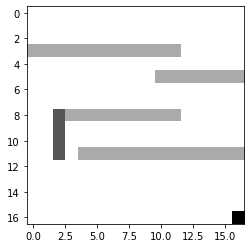

In [5]:
plt.imshow(S, cmap='binary')

State transition dynamics check

In [6]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE - 1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==1 and action==1) \
        or (S[curr]==2 and action==3) \
        or (S[s_new]==1 and action==0)\
        or (S[s_new]==2 and action==2):
        return True

    return False

We assume that the environment assigns rewards using the following reward function. Note that this reward function is not known to the agent, but rather it gets only samples of rewards and next states given the current state and action.  

In [7]:
def R(s, a):
    '''Reward function for the agent
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return R_GOAL
    elif hit_wall(s, a):
        return R_HIT_WALL
    else:
        return R_STEP

We define a utility function s_next_calc, which calculates the next state given current state and action:

In [8]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: Chosen action by the agent
    : returns: New state coordinates in the grid
    '''
    return (s[0] + A[a][0], s[1] + A[a][1])

The agent will use the following function to stochastically perform an action and obtains the next state and the associated reward.

In [9]:
def step(s, a):
    '''This function stochastically performs the action 'a' on the given
    state s.
    : param s: Current position of the agent
    : param a: Chosen action by the agent
    : returns: New state coordinates in the grid and the reward
    '''
    action_list = [a]
    cum_prob_list = [1 - ALPHA]  
    prob_left = ALPHA / 4  
    for action in range(len(A)):
        if action != a:
            action_list.append(action) 
            cum_prob_list.append(prob_left)

    action_taken = random.choices(action_list, cum_weights=cum_prob_list)[0]
    r = R(s, action_taken)
    if r == R_HIT_WALL or R_GOAL: # can't move
        s_next = s
    else:
        s_next = s_next_calc(s, action_taken)
    return s_next, r

We will use the following epsilon-greedy choice of an action

In [10]:
def choose_action_epsilon(Q, s, epsilon):
    """return a string action"""
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, len(A)-1)
    return np.argmax(Q[s[0], s[1], :])
    

**Remider**: Q-learning algorithm is:
![Screen%20Shot%202022-05-01%20at%204.51.08%20PM.png](attachment:Screen%20Shot%202022-05-01%20at%204.51.08%20PM.png)

In [11]:
def plot_policy_from_qtable(Q, msg=""):
    '''This function plots the policy learned from Q-Learning
    :param Q: Q-table
    '''
    plt.title(msg)
    policy = np.argmax(Q, axis=2)
    plt.imshow(np.max(Q, axis=2).reshape(GRID_SIZE,GRID_SIZE))
    quiver_action_dict = [
        [1, 0],
        [-1, 0],
        [0, -1],
        [0, 1],
        [0, 0]
    ]
        
    for k, v in np.ndenumerate(policy):
        plt.quiver(k[1], k[0], quiver_action_dict[v][1], quiver_action_dict[v][0])
    plt.show()

In [12]:
def plot_path_from_qtable(Q,start, msg=""):
    '''This function plots the policy learned from Q-Learning
    :param Q: Q-table
    '''
    plt.title(msg)
    policy = np.argmax(Q, axis=2)
    plt.imshow(np.max(Q, axis=2).reshape(GRID_SIZE,GRID_SIZE))
    quiver_action_dict = [
        [1, 0],
        [-1, 0],
        [0, -1],
        [0, 1],
        [0, 0]
    ]

    k = start
    while k!=GOAL:
        plt.quiver(k[1], k[0], quiver_action_dict[policy[k]][1], quiver_action_dict[policy[k]][0])
        k = (k[0] - quiver_action_dict[policy[k]][0] , k[1] + quiver_action_dict[policy[k]][1])
    plt.show()

In [13]:
#The agent uses the following function for Q-Learning:
def q_learning(gamma, episodes, epsilon, show=True):
    '''This function implements the Q-learning algorithm
    : param gamma: Discounting factor
    : param epsilon: probability not to take an optimal action
    : param episodes: Number of episodes for training
    : returns: dicounted accumulated reward
    '''
    plt.ion()

    # Q - Table
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(A_LIST)))

    # q-table check points
    Qs = []
    total_gamma = 1
    r_list = []
    sum_steps = 0
    for episode in range(episodes):
        s = START
        r_sum = 0
        i = 1

        while s != GOAL and i < EPISODE_LENGTH_MAX:
            # Pick the best known or random action according to eps
            a = choose_action_epsilon(Q, s, epsilon)
            # Take a random action with a transition probability ALPHA
            s_next, r = step(s, a)
            # Update Q table
            max_Q_next = np.max(Q[s_next]) #Q max to calculate temporal difference
            Q[s[0]][s[1]][a] +=   (r + (gamma * max_Q_next) - Q[s[0]][s[1]][a]) # took alpha - learning rate 1
            
            s = s_next #updating the current state to the next 
            
            r_sum += r #???
            i += 1
        sum_steps += i
        r_list.append(r_sum)
        if show:
            if (episode+1) % 10 == 0:
                clear_output(wait=True)
                plot_policy_from_qtable(Q, msg="Episode: {}".format(episode+1))

            if (episode+1) % (episodes//5) == 0:
                Qs.append(copy.deepcopy(Q))

    if show:
        #clear_output(wait=True)
        for i, q in enumerate(Qs):
            plot_policy_from_qtable(q, msg="Episode: {}".format((1+i)*(episodes//5)))
    return r_list,Q

In [14]:
#The agent uses the following function for Q-Learning:
def q_learning_start(gamma, episodes, epsilon,start = (0,0), show=True):
    '''This function implements the Q-learning algorithm
    : param gamma: Discounting factor
    : param epsilon: probability not to take an optimal action
    : param episodes: Number of episodes for training
    : returns: dicounted accumulated reward
    '''
    plt.ion()

    # Q - Table
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(A_LIST)))

    # q-table check points
    Qs = []
    total_gamma = 1
    r_list = []
    sum_steps = 0
    for episode in range(episodes):
        s = start
        r_sum = 0
        i = 1

        while s != GOAL and i < EPISODE_LENGTH_MAX:
            # Pick the best known or random action according to eps
            a = choose_action_epsilon(Q, s, epsilon)
            # Take a random action with a transition probability ALPHA
            s_next, r = step(s, a)
            # Update Q table
            max_Q_next = np.max(Q[s_next]) #Q max to calculate temporal difference
            Q[s[0]][s[1]][a] +=   (0.99) * (r + (gamma * max_Q_next) - Q[s[0]][s[1]][a]) # took alpha - learning rate 1
            
            s = s_next #updating the current state to the next 
            
            r_sum += r #???
            i += 1
        sum_steps += i
        r_list.append(r_sum)
        if show:
            if (episode+1) % 10 == 0:
                clear_output(wait=True)
                plot_policy_from_qtable(Q, msg="Episode: {}".format(episode+1))

            if (episode+1) % (episodes//5) == 0:
                Qs.append(copy.deepcopy(Q))

    if show:
        #clear_output(wait=True)
        for i, q in enumerate(Qs):
            plot_policy_from_qtable(q, msg="Episode: {}".format((1+i)*(episodes//5)))
    return r_list,Q

In [15]:
# example of running
episodes = 1000
gamma    = 0.975
epsilon  = 0.01
# r_list,Q = q_learning(gamma,  episodes, epsilon)

**Task 1**: run 5 times q_learning for episodes=1000, gamma=0.975 and epsilon = 0.01. 

Plot on plt.subplot(131) a) the curve of the accumulated discounted reward as a function of the episode number, averaged over these 5  runs, b) the variance of these 5 runs, using e.g., the function 'fill_between'. 

Plot on plt.subplot(132) a) the value function on the maze layout, V(s), for one of these 5 runs, and b) its corresponding optimal policy by arrows (UP, DOWN, etc), pi(s).

Plot on plt.subplot(133): 3 trajectories of states by an optimal policy from 3 random START states. 

--
add titles, axis labels, and legends.  

In [16]:
#Task-1-1 (a)
rewards = []
Q_2 = np.zeros((GRID_SIZE, GRID_SIZE, len(A_LIST)))
for a in range(0,5):
    r,Q_2=  q_learning(gamma,  episodes, epsilon, False)
    rewards.append(r)
rewards = np.array(rewards)
reward_avg = np.average(rewards,axis=0)


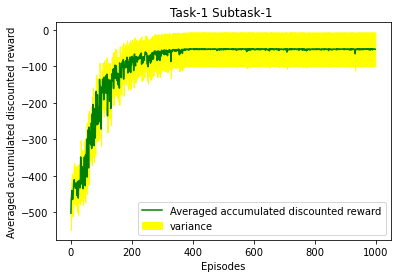

Variance : 8365.94449856


In [17]:
#Task-1-1 (b)
sd = np.std(reward_avg)
plt.fill_between(range(0,1000),reward_avg + (sd / 2), reward_avg - (sd/2),color = 'yellow',label="variance")
plt.title("Task-1 Subtask-1 ")
plt.xlabel("Episodes")
plt.ylabel("Averaged accumulated discounted reward")
plt.plot(reward_avg,color = 'green',label="Averaged accumulated discounted reward")
plt.legend()
plt.show()
print("Variance :" , sd**2)

C:\Users\rutvi\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\rutvi\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


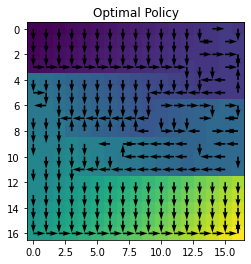

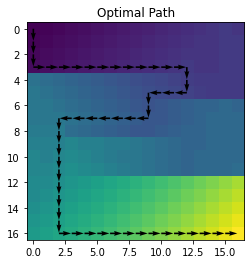

In [18]:
#Task-1-2 (a & b)
plot_policy_from_qtable(Q_2,"Optimal Policy")
plot_path_from_qtable(Q_2,START, "Optimal Path")

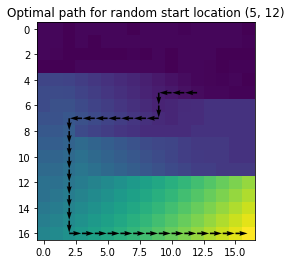

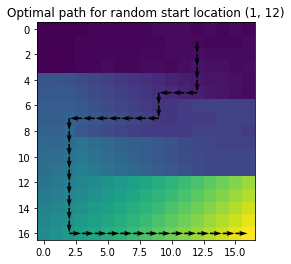

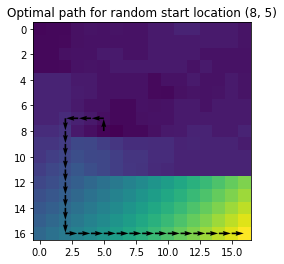

In [19]:
for i in range(0,3):
    start = (random.randint(0,14),random.randint(0,14))
    r,Q = q_learning_start(gamma,  episodes, epsilon,start, False)
    s = "Optimal path for random start location "  + str(start)  
    plot_path_from_qtable(Q,start, s)

In [20]:
def task2(epsilon,gamma,episodes):
    rewards = []
    START = (0,0)
    Q_2 = np.zeros((GRID_SIZE, GRID_SIZE, len(A_LIST)))
    for a in range(0,5):
        r,Q_2=  q_learning(gamma,  episodes, epsilon, False)
        rewards.append(r)
    rewards = np.array(rewards)
    reward_avg = np.average(rewards,axis=0)
   

    sd = np.std(reward_avg)
    plt.fill_between(range(0,1000),reward_avg + (sd / 2), reward_avg - (sd/2),color = 'yellow',label="variance")
    plt.title("Task-1 Subtask-1:"+ "epsilon=" +str(epsilon)+" "+ "gamma=" + str(gamma))
    plt.xlabel("Episodes")
    plt.ylabel("Averaged accumulated discounted reward")
    plt.plot(reward_avg,color = 'green',label="Averaged accumulated discounted reward")
    plt.legend()
    plt.show()
    print("Variance :" , sd**2)

    plot_policy_from_qtable(Q_2,"Optimal Policy:"+ "epsilon=" +str(epsilon)+" "+ "gamma=" + str(gamma))
    plot_path_from_qtable(Q_2,START, "Optimal Path:"+ "epsilon=" +str(epsilon)+" "+ "gamma=" + str(gamma))

    for i in range(0,3):
        start = (random.randint(0,14), random.randint(0,14))
        r,Q = q_learning_start(gamma,  episodes, epsilon,start, False)
        s = "Random start location "  + str(start) + "epsilon=" +str(epsilon)+" "+ "gamma=" + str(gamma)
        plot_path_from_qtable(Q,start, s)

**Task 2**: repeat Task 1 for epsilon = [0.005, 0.2] and gamma=[0.9, 0.75] and show the results on 4 different figures, respectively. Add a title to each figure indicating epsilon and gamma.

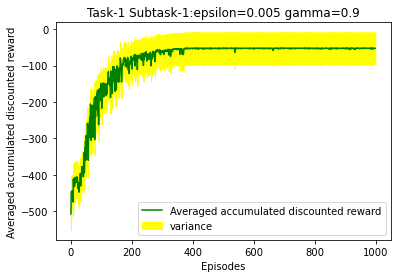

Variance : 7673.01951296


C:\Users\rutvi\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\rutvi\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


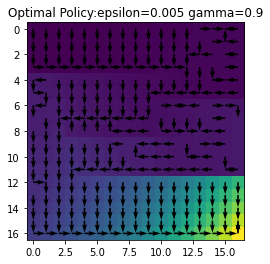

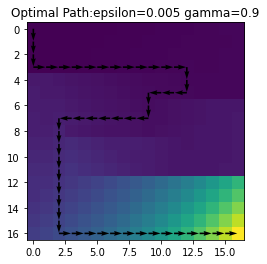

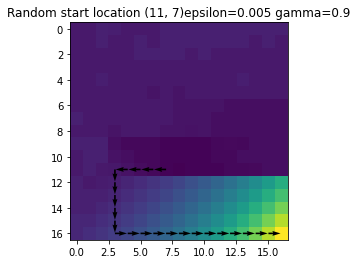

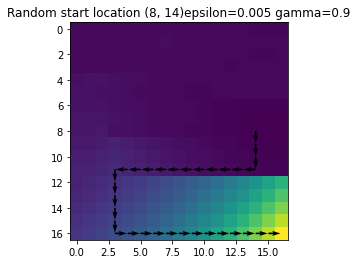

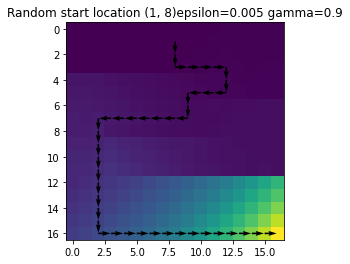

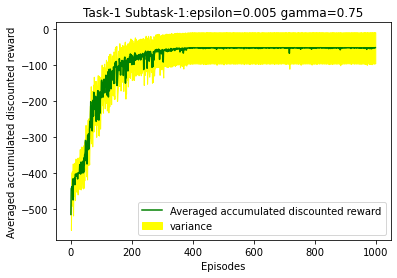

Variance : 7358.3725630399995


C:\Users\rutvi\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\rutvi\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


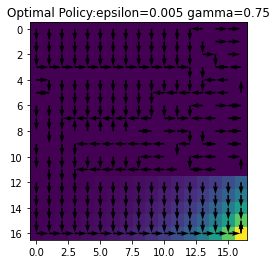

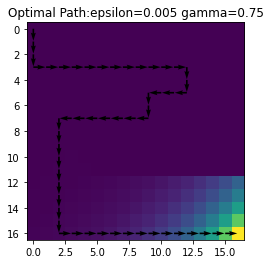

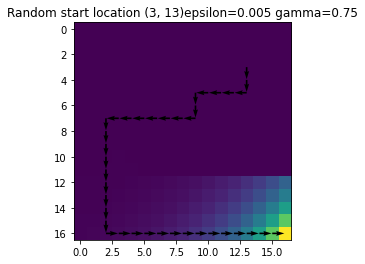

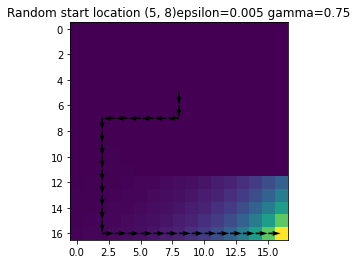

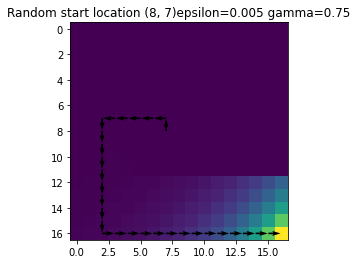

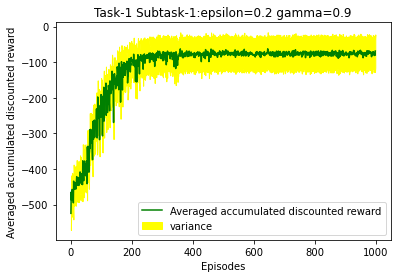

Variance : 8661.272224


C:\Users\rutvi\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\rutvi\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


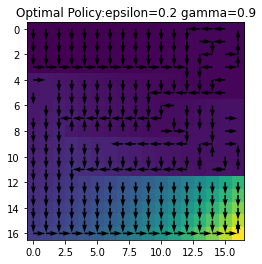

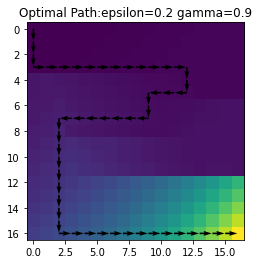

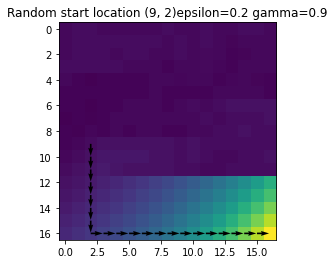

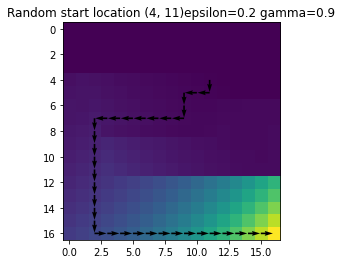

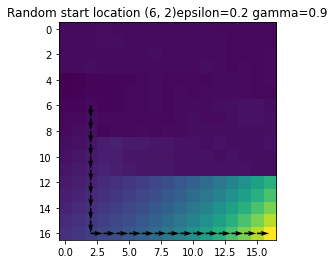

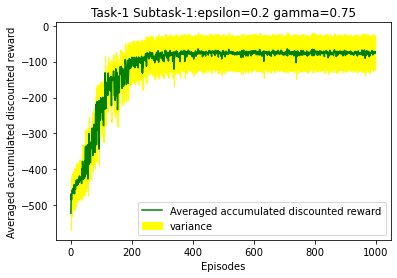

Variance : 8557.99140416


C:\Users\rutvi\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\rutvi\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


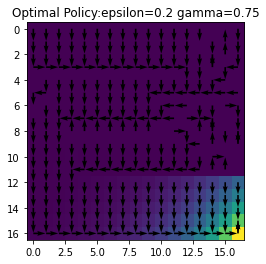

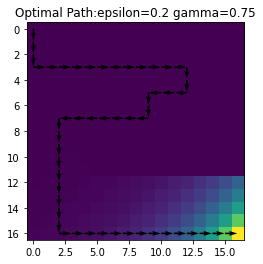

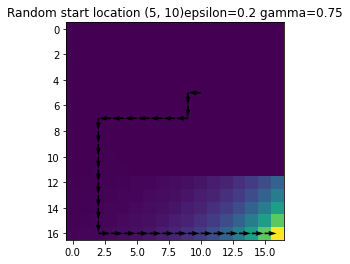

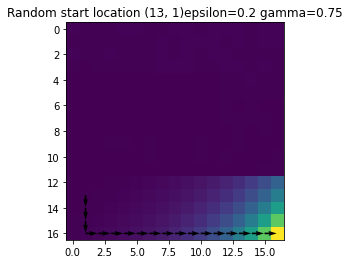

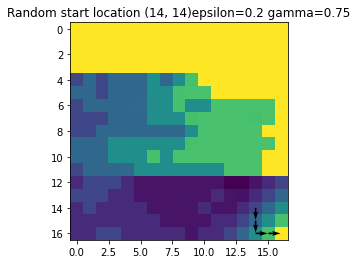

In [21]:
for epsi in [0.005,0.2]:
    for gam in [0.9,0.75]:
        gamma    = gam
        epsilon  = epsi
        task2(epsilon,gamma,episodes)

**Task 3**: explain your observations and conclusions. 

**Please submit this runnable notebook and a corresponding PDF.**

Gamma is multiplied by the optimal future value estimation in Q-learning. The gamma parameter determines the relevance of the following reward.
Gamma is a real number ranging from 0 to 1.   When gamma is set ≈ zero, the agent totally disregards future rewards. In  s uch case agents are only concerned with current benefits. However, if we set gamma to ≈ 1, the algorithm will seek out high rewards in the long run. A high gamma value could prohibit conversion: adding non-discounted rewards results in high Q-values.

Epsilon  parameter is related to the epsilon-greedy action selection procedure in the Q-learning algorithm. We choose the precise action in the action selection stage based on the Q-values we already have. The epsilon option adds randomization to the process, forcing us to experiment with different behaviors. This helps to avoid becoming caught in a local optimum. When epsilon is set ≈ 0, we never explore but always use what we already know. On the other hand, setting epsilon ≈ 1 forces the algorithm to always conduct random actions and never use prior information. Epsilon is usually chosen as a tiny value close to 0.

The learning rate or step size is defined by alpha . As seen in the equation of Q, the new Q-value for the state is computed by multiplying the old Q-value by alpha multiplied by the Q-value of the selected action.

We can say that our reward function is indirectly dependent on epsilon as we select the action based on that, and the Q table is dependent on gamma. By the plot of reward -> episodes we can determine that with higher epsilon(0.2) our average reward will be more distorted compared to lesser epsilon(0.05). With higher value of gamma(0.9) agent will explore the larger area of maze compared to lesser value (0.75).